# Import Libraries

In [1]:
import keras
import pandas as pd
import numpy as np
import random
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import roc_auc_score
import math
from scipy.stats import spearmanr, pearsonr
from matplotlib import pyplot as plt

Using TensorFlow backend.


# Import Data

In [2]:
cc_data=pd.read_csv("D:\Kaggle\Credit_card_fraud\creditcard.csv")
cc_data=cc_data[["V1","V2","V3","V4","Class"]]
cc_data.head()

,V1,V2,V3,V4,Class
0,-1.359807,-0.072781,2.536347,1.378155,0
1,1.191857,0.266151,0.166480,0.448154,0
2,-1.358354,-1.340163,1.773209,0.379780,0
3,-0.966272,-0.185226,1.792993,-0.863291,0
4,-1.158233,0.877737,1.548718,0.403034,0


In [3]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

In [4]:
def undersample(data ,target ,req_bad_rate):
    ori_bad_rate=list(data[target].value_counts(normalize = True))[1]
    print("Öriginal bad rate is {0}% and sample size is {1}".format(ori_bad_rate*100,len(data[target])))
    good_prop=((ori_bad_rate/req_bad_rate)*(len(data[target]))-list(data[target].value_counts())[1])/list(data[target].value_counts())[0]
    good_count=int(list(data[target].value_counts())[0]*good_prop)
    undersampled_data=data[data[target]==0].sample(good_count).append(data[data[target]==1])
    print("New bad rate is {0}% and sample size is {1}".format(list(undersampled_data[target].value_counts(normalize = True))[1]*100,len(undersampled_data[target])))
    return undersampled_data

# Undersample Goods

In [5]:
undersampled_data=undersample(cc_data,"Class",0.05)
X = undersampled_data.iloc[:,0:4]
y = undersampled_data.iloc[:,4]

Öriginal bad rate is 0.1727485630620034% and sample size is 284807
New bad rate is 5.0005081817257855% and sample size is 9839


# Initialize NN

In [6]:
model = Sequential()
model.add(Dense(2, input_dim=4, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3         
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit NN

In [10]:
model.fit(X, y, epochs=50, batch_size=50,verbose=0)
nn_pred = model.predict(X)
nn_pred=np.squeeze(nn_pred.T).tolist()
print("AUC ROC  for NN is: ",roc_auc_score(y,nn_pred))

AUC ROC  for NN is:  0.9653593040156356


# Extract weights and biases

In [11]:
weights0=model.layers[0].get_weights()
weights1=model.layers[1].get_weights()

In [12]:
logit00=list(weights0[0].T[0]) + [weights0[1][0]]
logit01=list(weights0[0].T[1]) + [weights0[1][1]]
logit10=list(weights1[0].T[0]) + [weights1[1][0]]

In [13]:
Xfl=X
Xfl["Intercept"]=[1 for x in range(len(Xfl["V1"]))]
a=Xfl.values

# Layer 0 logit calculation

In [14]:
logit00_o=[sigmoid(x) for x in list(np.dot(a,logit00))]
logit01_o=[sigmoid(x) for x in list(np.dot(a,logit01))]

# Layer 1 logit calculation

In [15]:
layer2=pd.DataFrame(np.asarray([logit00_o,logit01_o]).T)
layer2["Ïntercept"]=[1 for x in range(len(layer2.iloc[:,0]))]
b=layer2.values
logit10_o=[sigmoid(x) for x in list(np.dot(b,logit10))]

# Correlation between NN output and Logit composite

In [16]:
coef_rank, pr = spearmanr(nn_pred, logit10_o)
coef, p = pearsonr(nn_pred, logit10_o)
print('''Correlation coefficient between NN and logit is {0}.
Rank Correlation is {1}'''.format(coef,coef_rank))

Correlation coefficient between NN and logit is 0.9999999999999786.
Rank Correlation is 0.9999999555924619


# Plotting NN output and Composite Logit output

Text(0, 0.5, 'Logistic composite')

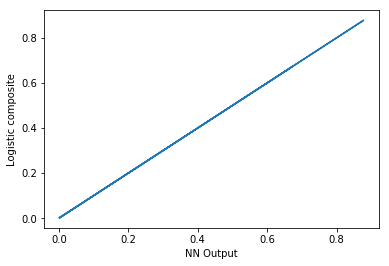

In [17]:
plt.plot(nn_pred,logit10_o)
plt.xlabel('NN Output')
plt.ylabel('Logistic composite')